In [1]:
### for 80mpc box
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.interpolate as interp
import scipy as sp
import re
from sklearn.neighbors import KDTree



#galaxy Mvir, x,y,z, vx, vy, vz
gals = np.loadtxt('hpropsRS.res', usecols=[5,6,7],unpack=1) 
# setting vx, vy, vz to be 0, so the position is in real space, to match the v=0 LOS



In [2]:
def unPackRawFile(raw_path):
    """
    - unpacks the Raw conditions file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    pec_vel = y[:,1]
    temp = y[:,2]
    HI_density = y[:,3]
    gas_density = y[:,4]
    gas_metallicity = y[:,5]
    
    return distance, pec_vel, temp, HI_density, gas_density, gas_metallicity

In [3]:
def getPos(path_LOS,linenumber=7):
    """
    the start position of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr

def getDir(path_LOS,linenumber=7):
    """
    the direction of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x.split(', ')[1]).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr


def convertSphereToCart(theta, phi):
    "converts a unit vector in spherical to cartesian, needed for getGalaxies"
    return np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

In [4]:
raw_path = 'los.00' + '{0:03}'.format(0) +'.raw'
direction = convertSphereToCart(getDir(raw_path)[0],getDir(raw_path)[1])
direction

array([ 0.6380884 , -0.76918308,  0.03464939])

In [5]:
##return the distance in extended instead
def lyman_identification():
    """
    function for identifying lls using neutral fraction as filter
    """
    neutral_fraction_limit = 1e-3
    data = []
    l_bases = []
    r_bases = []

    for i in range(1000):
        raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
        distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
        #changing the distance from chimp to cmeters
        distance_cm = distance *0.1474*3.086e24 /0.68
        temp_data =[]
        temp_left =[]
        temp_right = []
        position = getPos(raw_path)
        direction = convertSphereToCart(getDir(raw_path)[0],getDir(raw_path)[1])
        for k in range(len(distance) -2):
            if(HI_density[k]/gas_density[k]<neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]>neutral_fraction_limit):
                left_bases = k
                peak_fraction = HI_density[k]/gas_density[k]
                peak_HI = HI_density[k]
                peak_distance = distance[k]
                if( k+1 <len(distance)):
                    while(not(HI_density[k]/gas_density[k]>neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]<neutral_fraction_limit) and k <len(distance)-1):
                        right_bases = k
                        if(k<len(distance)-1):
                            k+=1
                        if(HI_density[k]/gas_density[k]>peak_fraction):
                            peak_fraction = HI_density[k]/gas_density[k]
                            peak_HI = HI_density[k]
                            peak_distance = distance[k]
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    if(area_under >= (1.6*10**17)and area_under  <= (10**20)):
                        real_distance = [(position[0]/512*80 + direction[0]*peak_distance)%80,(position[1]/512*80 + direction[1]*peak_distance)%80,(position[2]/512*80 + direction[2]*peak_distance)%80]
                        data.append(real_distance)
                        temp_left.append(distance[left_bases])
                        temp_right.append(distance[right_bases])
        l_bases.append(temp_left)
        r_bases.append(temp_right)
    return data,l_bases,r_bases
lyman_limited_value,left_bases,right_bases = lyman_identification()

In [91]:
len(lyman_limited_value)

1983

In [6]:
#need the change this to iterate through individual lls instead of the whole thing
points = []
for i,j,k in zip(gals[0],gals[1],gals[2]):
    points.append([i,j,k])
for z in lyman_limited_value:
    points.append(z)

In [7]:
"""from scipy.spatial import distance
for i in lyman_limited_value:
    points.append(i)
    distance = distance.squareform(distance.pdist(points))
    points.remove(i)
    print(distance)"""


'from scipy.spatial import distance\nfor i in lyman_limited_value:\n    points.append(i)\n    distance = distance.squareform(distance.pdist(points))\n    points.remove(i)\n    print(distance)'

In [107]:
def nns(points,lyman_limited_value,k_points):
    tree = KDTree(points)
    #all_nn_indices = tree.query_radius(points, r = 1)
    nearest_dist, all_nn_indices = tree.query(points, k=k_points)
    nns = []
    for i in range(len(all_nn_indices)-len(lyman_limited_value),len(all_nn_indices)):
        nns.append(all_nn_indices[i])
    all_nns = [
        [points[idx] for idx in nn_indices if idx != int(i+len(all_nn_indices)-len(lyman_limited_value))]
        for i, nn_indices in enumerate(nns)
    ]
    neighbors = []
    for nns in all_nns:
        neighbors.append(nns)
    all_distance_diff = []
    temp_distance = []
    for i,k in zip(neighbors,lyman_limited_value):
        all_distance_diff.append(temp_distance)
        temp_distance = []
        for ii in i:
                temp_distance.append(np.sqrt((ii[0]-k[0])**2+(ii[1]-k[1])**2+(ii[2]-k[2])**2))
    plot_data  = []
    for i in all_distance_diff:
        for k in i:
            plot_data.append(k)
    counts,bins = np.histogram(plot_data,bins=50)
    total = np.sum(counts)
    probability = []
    for i in range(len(counts)):
        probability.append(counts[i]/total)
    cumulative_probability = []
    cumulative_probability.append(probability[0])
    for i in range(1,len(probability)):
        cumulative_probability.append(probability[i]+cumulative_probability[i-1])
    cumulative_probability
    return cumulative_probability,counts,bins

/tmp/ipykernel_13058/3273386379.py:12: RuntimeWarning: divide by zero encountered in log10
  y2 = np.log10(np.subtract(1,cumulative_probability))
/tmp/ipykernel_13058/3273386379.py:28: RuntimeWarning: divide by zero encountered in log10
  y2 = np.log10(np.subtract(1,cumulative_probability))


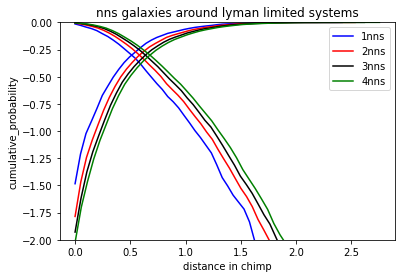

In [108]:
#iterate through each lls instead not includng other stuff
cumulative_probability,counts,bins = nns(points,lyman_limited_value,2)
y = np.log10(cumulative_probability)
y2 = np.log10(np.subtract(1,cumulative_probability))
x = np.linspace(0,bins[-1] ,50)
plt.plot(x,y,label = str(2-1)+"nns",c="blue")
plt.plot(x,y2,c="blue")
plt.ylim(-2,0)
plt.legend()
cumulative_probability,counts,bins = nns(points,lyman_limited_value,3)
y = np.log10(cumulative_probability)
y2 = np.log10(np.subtract(1,cumulative_probability))
x = np.linspace(0,bins[-1] ,50)
plt.plot(x,y,label = str(3-1)+"nns",c="red")
plt.plot(x,y2,c="red")
plt.ylim(-2,0)
plt.legend()
cumulative_probability,counts,bins = nns(points,lyman_limited_value,4)
y = np.log10(cumulative_probability)
y2 = np.log10(np.subtract(1,cumulative_probability))
x = np.linspace(0,bins[-1] ,50)
plt.plot(x,y,label = str(4-1)+"nns",c="black")
plt.plot(x,y2,c="black")
plt.ylim(-2,0)
plt.legend()
cumulative_probability,counts,bins = nns(points,lyman_limited_value,5)
y = np.log10(cumulative_probability)
y2 = np.log10(np.subtract(1,cumulative_probability))
x = np.linspace(0,bins[-1] ,50)
plt.plot(x,y,label = str(5-1)+"nns",c="green")
plt.plot(x,y2,c="green")
plt.title("nns galaxies around lyman limited systems")
plt.ylabel("cumulative_probability")
plt.xlabel("distance in chimp")
plt.ylim(-2,0)
plt.legend()
plt.savefig("nns_lls.png")

In [109]:
cumulative_probability,counts,bins = nns(points,lyman_limited_value,2)
bins


array([0.00421   , 0.05246718, 0.10072437, 0.14898155, 0.19723874,
       0.24549592, 0.2937531 , 0.34201029, 0.39026747, 0.43852466,
       0.48678184, 0.53503902, 0.58329621, 0.63155339, 0.67981058,
       0.72806776, 0.77632494, 0.82458213, 0.87283931, 0.92109649,
       0.96935368, 1.01761086, 1.06586805, 1.11412523, 1.16238241,
       1.2106396 , 1.25889678, 1.30715397, 1.35541115, 1.40366833,
       1.45192552, 1.5001827 , 1.54843989, 1.59669707, 1.64495425,
       1.69321144, 1.74146862, 1.78972581, 1.83798299, 1.88624017,
       1.93449736, 1.98275454, 2.03101173, 2.07926891, 2.12752609,
       2.17578328, 2.22404046, 2.27229765, 2.32055483, 2.36881201,
       2.4170692 ])

In [110]:
probability

[0.05600403632694248,
 0.04490413723511604,
 0.06004036326942482,
 0.08375378405650857,
 0.08728557013118063,
 0.09485368314833502,
 0.08779011099899092,
 0.08526740665993945,
 0.08678102926337034,
 0.05953582240161453,
 0.05196770938446014,
 0.03834510595358224,
 0.036831483350151364,
 0.031786074672048435,
 0.020686175580221997,
 0.02119071644803229,
 0.017154389505549948,
 0.010090817356205853,
 0.006054490413723511,
 0.005045408678102927,
 0.006559031281533804,
 0.0020181634712411706,
 0.0020181634712411706,
 0.0015136226034308778,
 0.0010090817356205853,
 0.0,
 0.0,
 0.0005045408678102926,
 0.0,
 0.0010090817356205853]